![alt text](https://camo.githubusercontent.com/d464ca86de08d7173fcccc38ec0c840a6da02cea/68747470733a2f2f656e676d726b2e636f6d2f77702d636f6e74656e742f75706c6f6164732f323031382f30392f4c654e65745f4f726967696e616c5f496d6167652e6a7067)

![alt text](https://camo.githubusercontent.com/9028f39092178a1b65f243eb8b471ebd84920cec/68747470733a2f2f656e676d726b2e636f6d2f77702d636f6e74656e742f75706c6f6164732f323031382f30392f4c654e45745f53756d6d6172795f5461626c652e6a7067)

In [0]:
import torch
import random
import numpy as np

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

In [0]:
import torchvision.datasets

In [0]:
MNIST_train = torchvision.datasets.MNIST('./', download=True, train=True)
MNIST_test = torchvision.datasets.MNIST('./', download=True, train=False)

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw
Processing...
Done!


In [0]:
X_train = MNIST_train.train_data
y_train = MNIST_train.train_labels
X_test = MNIST_test.test_data
y_test = MNIST_test.test_labels

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:45: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:60: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:50: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


In [0]:
len(y_train), len(y_test)

(60000, 10000)

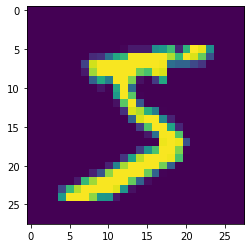

tensor(5)


In [0]:
import matplotlib.pyplot as plt
plt.imshow(X_train[0, :, :])
plt.show()
print(y_train[0])

In [0]:
# Хотим к сеть давать картинку как трехмерный  тензор (каналы, размеры).
# То есть разжимаем из 28x28 в 1x28x28
# Тут в X_train лежит 60000 картинок т.к. 60000x28x28 ->  60000x1x28x28
X_train = X_train.unsqueeze(1).float()
X_test = X_test.unsqueeze(1).float()

In [0]:
X_train.shape

torch.Size([60000, 1, 28, 28])

In [0]:
class LeNet5(torch.nn.Module):
    def __init__(self):
        # две свертки + три полносвязных слоя
        super(LeNet5, self).__init__()

        self.conv1 = torch.nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, padding=2)
        self.act1 = torch.nn.Tanh()
        self.pool1 = torch.nn.AvgPool2d(kernel_size=2, stride=2)  # выходной размер изобр 14x14

        self.conv2 = torch.nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, padding=0)
        self.act2 = torch.nn.Tanh()
        self.pool2 = torch.nn.AvgPool2d(kernel_size=2, stride=2)  # выходной размер изобр 5x5

        self.fc1 = torch.nn.Linear(5*5*16, 120)  # до этого уже растянуля изобр. в вектрор 5x5x16
        self.act3 = torch.nn.Tanh()

        self.fc2 = torch.nn.Linear(120, 84) 
        self.act4 = torch.nn.Tanh()

        self.fc3 = torch.nn.Linear(84, 10) 

    def forward(self, x):
        # x - батч из картинок
        x = self.conv1(x)
        x = self.act1(x)
        x = self.pool1(x)
        
        x = self.conv2(x)
        x = self.act2(x)
        x = self.pool2(x)

        # растянем 4-мерный тензор (размер батча/канал/ширина картинки/длина картинки)
        # в 2 -мерный тензор (размер батча/вектор из пред слоя)
        x = x.view(x.size(0), x.size(1) * x.size(2) * x.size(3)) 

        x = self.fc1(x)
        x = self.act3(x)
        x = self.fc2(x)
        x = self.act4(x)
        x = self.fc3(x)
        
        return x

lenet5 = LeNet5()

In [0]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
lenet5 = lenet5.to(device)

In [0]:
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(lenet5.parameters(), lr=1.0e-3)

In [0]:
# ОБУЧЕНИЕ
batch_size = 100

test_accuracy_history = []
test_loss_history = []

X_test = X_test.to(device)
y_test = y_test.to(device)

for epoch in range(10000):
    order = np.random.permutation(len(X_train))
    for start_index in range(0, len(X_train), batch_size):
        optimizer.zero_grad()
        
        batch_indexes = order[start_index:start_index+batch_size]
        
        X_batch = X_train[batch_indexes].to(device)
        y_batch = y_train[batch_indexes].to(device)
        
        preds = lenet5.forward(X_batch) 
        
        loss_value = loss(preds, y_batch)
        loss_value.backward()
        
        optimizer.step()
        
    test_preds = lenet5.forward(X_test)
    test_loss_history.append(loss(test_preds, y_test).data.cpu())
    
    accuracy = (test_preds.argmax(dim=1) == y_test).float().mean().data.cpu()
    test_accuracy_history.append(accuracy)
    
    print(accuracy)

tensor(0.9752)
tensor(0.9832)
tensor(0.9865)
tensor(0.9867)
tensor(0.9885)
tensor(0.9878)
tensor(0.9882)
tensor(0.9895)
tensor(0.9886)
tensor(0.9871)
tensor(0.9901)
tensor(0.9889)
tensor(0.9871)
tensor(0.9896)
tensor(0.9868)
tensor(0.9891)
tensor(0.9893)
tensor(0.9872)
tensor(0.9882)
tensor(0.9895)


KeyboardInterrupt: ignored

In [0]:
lenet5.forward(X_test)

tensor([[-3.1436,  0.4261, -1.5734,  ..., 15.1628, -2.7292,  4.6487],
        [ 0.1223,  0.1968, 17.7903,  ..., -3.2689,  2.9098, -5.1363],
        [-2.2049, 17.2645, -4.0622,  ...,  1.4741,  2.5799, -3.1600],
        ...,
        [-6.6327, -0.8500, -4.8177,  ...,  1.9861,  1.1951,  3.9089],
        [-1.2953, -3.8530, -6.9451,  ..., -6.1070,  5.1850, -2.9649],
        [ 1.1542, -4.9335,  1.7237,  ..., -8.8248, -0.3029, -4.2076]],
       device='cuda:0', grad_fn=<AddmmBackward>)

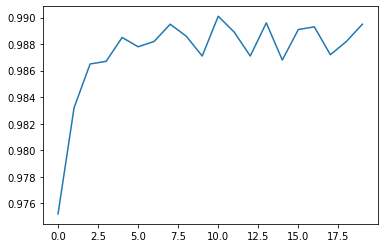

In [0]:
plt.plot(test_accuracy_history);
# plt.plot(test_loss_history);